In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time

In [2]:
#Stratification added to both variants
#08/02/21
#09/02/21
#11/02/21
#16/02/21
#17/02/21
#21/02/21

In [2]:
def AgeComorbidParms(i, j):
    #straitfy into age bands
    #j = 0, no comorbidities
    #j =/ 0, comorbidity states, currently coalesced into 1 large comorbidity state describing all comorbidities
    # i = 0 : 0-10, i = 1 : 11-20 etc.
    #currently set to arbitrary values loosely reflecting social contact patterns and health conditions
    if i == 0:
        if j == 0:
           beta = 0.32
           gamma = 0.20
           mu = 0.0001
        if j == 1:
           beta = 0.32
           gamma = 0.19
           mu = 0.0005
    # i = 1 : 11-20
    if i == 1:
        if j == 0:
           beta = 0.34
           gamma = 0.21
           mu = 0.0002
        if j == 1:
           beta = 0.34
           gamma = 0.20
           mu = 0.0007
    # i = 2 : 21-30
    if i == 2:
        if j == 0:
           beta = 0.35
           gamma = 0.19
           mu = 0.0003
        if j == 1:
           beta = 0.34
           gamma = 0.19
           mu = 0.0008
    # i = 3 : 31-40
    if i == 3:
        if j == 0:
           beta = 0.32
           gamma = 0.17
           mu = 0.001
        if j == 1:
           beta = 0.30
           gamma = 0.16
           mu = 0.0025 
    # i = 4 : 41-50
    if i == 4:
        if j == 0:
           beta = 0.3
           gamma = 0.16
           mu = 0.0015
        if j == 1:
           beta = 0.28
           gamma = 0.14
           mu = 0.0013    
    # i = 5 : 51-60
    if i == 5:
        if j == 0:
           beta = 0.28
           gamma = 0.13
           mu = 0.002
        if j == 1:
           beta = 0.26
           gamma = 0.11
           mu = 0.003  
    # i = 6 : 61-70
    if i == 6: 
        if j == 0:
           beta = 0.25
           gamma = 0.10
           mu = 0.0025
        if j == 1:
           beta = 0.24
           gamma = 0.095
           mu = 0.004   
    # i = 7 : 71-80
    if i == 7: 
        if j == 0:
           beta = 0.23
           gamma = 0.075
           mu = 0.005
        if j == 1:
           beta = 0.20
           gamma = 0.06
           mu = 0.02    
    # i = 8 : 81+
    if i == 8:
        if j == 0:
           beta = 0.20
           gamma = 0.06
           mu = 0.01
        if j == 1:
           beta = 0.16
           gamma = 0.03
           mu = 0.05
    return beta, gamma, mu

In [3]:
"""
Deterministic variant
Refer to https://www.aimath.org/WWN/populationmodel/chapmar25.pdf for theoretical basis
11/12/20
"""
def SIRDet(incubation, N, dt, I0, time, vac_start, vac_eff):
    #all given rates per day, dt as fraction of day, e.g. dt=1 is 1 day
    #beta = average number of infective contacts per person per day
    #gamma = recovery rate per day
    #mu = death rate per day
    t = np.arange(0,time,dt)
    n = len(t)
    alpha = 1/incubation
    #divisions of population into healthy and comorbid groups based on 10 year stratified age bands
    #Population divisions go from younger to older (left to right) in 10 year bands up to 80+
    demographic_healthy = [N/18, N/18, N/18, N/18, N/18, N/18, N/18, N/18, N/18]
    demographic_comorbid = [N/18, N/18, N/18, N/18, N/18, N/18, N/18, N/18, N/18]
    #initialise where the initial infected population are in the model
    infected_healthy = [0,0,0,I0,0,0,0,0,0]
    infected_comorbid = [0,0,0,0,0,0,0,0,0]
    
    #3d initialised arrays for data, dimensions correspond to time, age band, comorbidity respectively
   
    S = np.zeros((n,9,2)) #susceptible
    E = np.zeros((n,9,2)) #exposed 
    I = np.zeros((n,9,2)) #infected
    R = np.zeros((n,9,2)) #recovered
    D = np.zeros((n,9,2)) #dead
    T = np.zeros((n,9,2)) #total cases, includes infected, recovered and dead
    Q = np.zeros((n,9,2)) #quarantined, not currently in use
    H = np.zeros((n,9,2)) #hospitalised, not currently in use
    V = np.zeros((n,9,2)) #vaccination
    V_s = np.zeros((n,9,2)) #vaccinated gained immunity
    V_f = np.zeros((n,9,2)) #vaccinated not gained immunity
    V_c = np.zeros((n,9,2)) #cumulative vaccine
    
    #New 1D arrays to hold sum of population across strata, aka total population at each timestep
    #Implemented in attempt to fix bug in data presentation
    S_t = np.zeros(n) #susceptible
    E_t = np.zeros(n) #exposed
    I_t = np.zeros(n) #infected
    R_t = np.zeros(n) #recovered
    D_t = np.zeros(n) #dead
    T_t = np.zeros(n) #total cases, includes infected, recovered and dead
    Q_t = np.zeros(n) #quarantined, not currently in use
    H_t = np.zeros(n) #hospitalised, not currently in use
    V_t = np.zeros(n) #vaccination
    V_s_t = np.zeros(n) #vaccinated gained immunity
    V_f_t = np.zeros(n) #vaccinated not gained immunity
    V_c_t = np.zeros(n) #cumulative vaccine
    
    for p in range(1,n):
        
        if p >= (vac_start/dt):
            vac_rate = 0.25
        else:
            vac_rate = 0
    
    
    
        for i in range(0,9):
            for j in range (0,2):
            
                #chooses initial population for each stratified group from arrays above
                if j == 0:
                    N_ini = demographic_healthy[i]
                    I_ini = infected_healthy[i]
                if j == 1:
                    N_ini = demographic_comorbid[i]
                    I_ini = infected_comorbid[i]
                
                #initialises populations for 3D arrays
                S[0,i,j] = N_ini - I_ini
                I[0,i,j] = I_ini
                T[0,i,j] = I[0,i,j]
                #initialises populations for 1D arrays
                S_t[0] = np.sum(S[0,])
                I_t[0] = np.sum(I[0,])
                T_t[0] = np.sum(T[0,])
                
                #Sets parameters
                beta = AgeComorbidParms(i,j)[0]
                gamma = AgeComorbidParms(i,j)[1]
                mu = AgeComorbidParms(i,j)[2]
    
               
    
    
            
    
                S[p,i,j] = (-beta*S[p-1,i,j]*(np.sum(I[p-1])+np.sum(E[p-1]))/N - vac_rate*S[p-1,i,j])*dt + S[p-1,i,j] 
                E[p,i,j] = (beta*S[p-1,i,j]*(np.sum(I[p-1])+np.sum(E[p-1]))/N + beta*V_f[p-1,i,j]*(np.sum(I[p-1])\
                +np.sum(E[p-1]))/N - alpha*E[p-1,i,j])*dt + E[p-1,i,j]
                I[p,i,j] = (alpha*E[p-1,i,j] - gamma*I[p-1,i,j] - mu*I[p-1,i,j])*dt + I[p-1,i,j]
                R[p,i,j] = (gamma*I[p-1,i,j])*dt + R[p-1,i,j]
                D[p,i,j] = (mu*I[p-1,i,j])*dt + D[p-1,i,j]
                V_s[p,i,j] = ((vac_eff/100)*vac_rate*S[p-1,i,j])*dt + V_s[p-1,i,j]
                V_f[p,i,j] = ((1-vac_eff/100)*vac_rate*S[p-1,i,j] - beta*V_f[p-1,i,j]*(np.sum(I[p-1])+np.sum(E[p-1])/N))*dt\
                + V_f[p-1,i,j]
                V_c[p,i,j] = (vac_rate*S[p-1,i,j])*dt + V_c[p-1,i,j]
                T[p,i,j] = I[p,i,j] + R[p,i,j] + D[p,i,j]
        
        S_t[p] = np.sum(S[p,])
        E_t[p] = np.sum(E[p,])
        I_t[p] = np.sum(I[p,])
        R_t[p] = np.sum(R[p,])
        D_t[p] = np.sum(D[p,])
        V_s_t[p] = np.sum(V_s[p,])
        V_f_t[p] = np.sum(V_f[p,])
        V_c_t[p] = np.sum(V_c[p,])
        T_t[p] = np.sum(T[p,])
    return{'t':t,'S':S_t,'E':E_t, 'I':I_t, 'R':R_t, 'D':D_t,\
           'Vaccinated':V_s_t, 'Cumulative Vaccinated': V_c_t,  'Total Cases':T_t}


"""
Stochastic variant
Refer to https://www.aimath.org/WWN/populationmodel/chapmar25.pdf for theoretical basis
11/12/20
Add multinomial distribution for infected compartment
"""


def SIRSto(incubation, N, dt, I0, time, vac_start, vac_eff):
    #all given rates per day, dt as fraction of day, e.g. dt=1 is 1 day
    #beta = average number of infective contacts per person per day
    #gamma = recovery rate per day
    #mu = death rate per day
    t = np.arange(0,time,dt)
    n = len(t)
    alpha = 1/incubation
    #divisions of population into healthy and comorbid groups based on 10 year stratified age bands
    #Population divisions go from younger to older (left to right) in 10 year bands up to 80+
    demographic_healthy = [N/18, N/18, N/18, N/18, N/18, N/18, N/18, N/18, N/18]
    demographic_comorbid = [N/18, N/18, N/18, N/18, N/18, N/18, N/18, N/18, N/18]
    #initialise where the initial infected population are in the model
    infected_healthy = [0,0,0,I0,0,0,0,0,0]
    infected_comorbid = [0,0,0,0,0,0,0,0,0]
    
    #3d initialised arrays for data, dimensions correspond to time, age band, comorbidity respectively
   
    S = np.zeros((n,9,2)) #susceptible
    E = np.zeros((n,9,2)) #exposed 
    I = np.zeros((n,9,2)) #infected
    R = np.zeros((n,9,2)) #recovered
    D = np.zeros((n,9,2)) #dead
    T = np.zeros((n,9,2)) #total cases, includes infected, recovered and dead
    Q = np.zeros((n,9,2)) #quarantined, not currently in use
    H = np.zeros((n,9,2)) #hospitalised, not currently in use
    V = np.zeros((n,9,2)) #vaccination
    V_s = np.zeros((n,9,2)) #vaccinated gained immunity
    V_f = np.zeros((n,9,2)) #vaccinated not gained immunity
    V_c = np.zeros((n,9,2)) #cumulative vaccine
    
    #New 1D arrays to hold sum of population across strata, aka total population at each timestep
    #Implemented in attempt to fix bug in data presentation
    S_t = np.zeros(n) #susceptible
    E_t = np.zeros(n) #exposed
    I_t = np.zeros(n) #infected
    R_t = np.zeros(n) #recovered
    D_t = np.zeros(n) #dead
    T_t = np.zeros(n) #total cases, includes infected, recovered and dead
    Q_t = np.zeros(n) #quarantined, not currently in use
    H_t = np.zeros(n) #hospitalised, not currently in use
    V_t = np.zeros(n) #vaccination
    V_s_t = np.zeros(n) #vaccinated gained immunity
    V_f_t = np.zeros(n) #vaccinated not gained immunity
    V_c_t = np.zeros(n) #cumulative vaccine
    
   
    
    
    for p in range(1,n):
        
        
        
        if p >= (vac_start/dt):
            vac_rate = 0.25
        else:
            vac_rate = 0
            
        for i in range(0,9):
            for j in range (0,2):
            
                #chooses initial population for each stratified group from arrays above
                if j == 0:
                    N_ini = demographic_healthy[i]
                    I_ini = infected_healthy[i]
                if j == 1:
                    N_ini = demographic_comorbid[i]
                    I_ini = infected_comorbid[i]
                
                #initialises populations for 3D arrays
                S[0,i,j] = N_ini - I_ini
                I[0,i,j] = I_ini
                T[0,i,j] = I[0,i,j]
                #initialises populations for 1D arrays
                S_t[0] = np.sum(S[0,])
                I_t[0] = np.sum(I[0,])
                T_t[0] = np.sum(T[0,])
                
                #Sets parameters
                beta = AgeComorbidParms(i,j)[0]
                gamma = AgeComorbidParms(i,j)[1]
                mu = AgeComorbidParms(i,j)[2]
    
                
    
            
                leavingsus = np.random.multinomial(S[p-1,i,j],[1-np.exp((-beta*(np.sum(I[p-1])+np.sum(E[p-1]))/N)*dt),\
                1-np.exp(-(vac_eff/100)*vac_rate*dt), 1-np.exp(-(1-vac_eff/100)*vac_rate*dt),
                1-(1-np.exp((-beta*(np.sum(I[p-1])+np.sum(E[p-1]))/N)*dt)\
                +1-np.exp(-(vac_eff/100)*vac_rate*dt)+1-np.exp(-(1-vac_eff/100)*vac_rate*dt))])
                expnew = leavingsus[0]
                vacnew_s = leavingsus[1]
                vacnew_f = leavingsus[2]
                infnew = np.random.binomial(E[p-1,i,j],1-np.exp(-alpha*dt))
                leavinginf = np.random.multinomial(I[p-1,i,j], [1-np.exp(-gamma*dt), 1-np.exp(-mu*dt),\
                1-(1-np.exp(-gamma*dt)+1-np.exp(-mu*dt))])
                recnew = leavinginf[0]
                deadnew = leavinginf[1]
                vacexp = np.random.binomial(V_f[p-1,i,j], 1-np.exp((-beta*(np.sum(I[p-1])+np.sum(E[p-1])/N))))
                S[p,i,j] = S[p-1,i,j] - expnew - vacnew_s - vacnew_f
                E[p,i,j] = E[p-1,i,j] + expnew - infnew + vacexp
                I[p,i,j] = I[p-1,i,j] + infnew - recnew - deadnew
                R[p,i,j] = R[p-1,i,j] + recnew
                D[p,i,j] = D[p-1,i,j] + deadnew
                V_s[p,i,j] = V_s[p-1,i,j] + vacnew_s
                V_f[p,i,j] = V_f[p-1,i,j] + vacnew_f - vacexp
                V_c[p,i,j] = V_c[p-1,i,j] + vacnew_s + vacnew_f
                T[p,i,j] = I[p,i,j] + R[p,i,j] + D[p,i,j]
        
        S_t[p] = np.sum(S[p,])
        E_t[p] = np.sum(E[p,])
        I_t[p] = np.sum(I[p,])
        R_t[p] = np.sum(R[p,])
        D_t[p] = np.sum(D[p,])
        V_s_t[p] = np.sum(V_s[p,])
        V_f_t[p] = np.sum(V_f[p,])
        V_c_t[p] = np.sum(V_c[p,])
        T_t[p] = np.sum(T[p,])
    return{'t':t,'S':S_t,'E':E_t, 'I':I_t, 'R':R_t, 'D':D_t,\
           'Vaccinated':V_s_t, 'Cumulative Vaccinated': V_c_t,  'Total Cases':T_t}

In [8]:
sir_out = pd.DataFrame(SIRSto(5, 100000, 0.1, 10, 300, 301, 70))


In [7]:
sir_out_det = pd.DataFrame(SIRDet(5, 100000, 0.1, 1, 300, 301, 70))

In [9]:
pd.set_option('display.max_rows', None)
sir_out

,t,S,E,I,R,D,Vaccinated,Cumulative Vaccinated,Total Cases
0,0.0,99990.0,0.0,10.0,0.0,0.0,0.0,0.0,10.0
1,0.1,99989.0,1.0,10.0,0.0,0.0,0.0,0.0,10.0
2,0.2,99989.0,1.0,10.0,0.0,0.0,0.0,0.0,10.0
3,0.3,99989.0,1.0,10.0,0.0,0.0,0.0,0.0,10.0
4,0.4,99989.0,1.0,10.0,0.0,0.0,0.0,0.0,10.0
5,0.5,99988.0,2.0,10.0,0.0,0.0,0.0,0.0,10.0
6,0.6,99988.0,2.0,10.0,0.0,0.0,0.0,0.0,10.0
7,0.7,99988.0,2.0,10.0,0.0,0.0,0.0,0.0,10.0
8,0.8,99988.0,2.0,10.0,0.0,0.0,0.0,0.0,10.0
9,0.9,99988.0,2.0,10.0,0.0,0.0,0.0,0.0,10.0


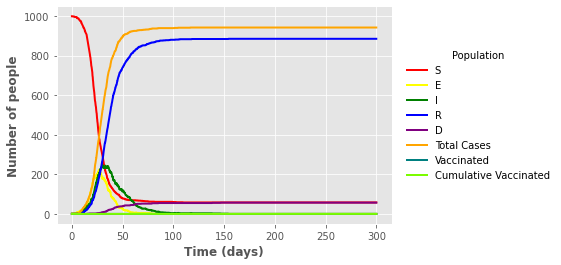

In [15]:
#stochastic
plt.style.use("ggplot")
sline = plt.plot("t","S","",data=sir_out,color="red",linewidth=2)
eline = plt.plot("t","E","",data=sir_out,color="yellow",linewidth=2)
iline = plt.plot("t","I","",data=sir_out,color="green",linewidth=2)
rline = plt.plot("t","R","",data=sir_out,color="blue",linewidth=2)
dline = plt.plot("t","D","",data=sir_out,color="purple",linewidth=2)
tline = plt.plot("t","Total Cases","",data=sir_out,color="orange",linewidth=2)
vline = plt.plot("t","Vaccinated","",data=sir_out,color="teal",linewidth=2)
vcline = plt.plot("t","Cumulative Vaccinated","",data=sir_out,color="lawngreen",linewidth=2)
plt.xlabel("Time (days)",fontweight="bold")
plt.ylabel("Number of people",fontweight="bold")
legend = plt.legend(title="Population",loc=5,bbox_to_anchor=(1.50,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)

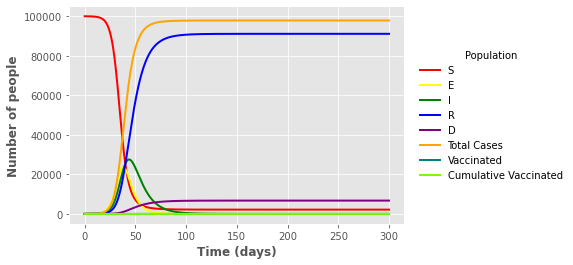

In [7]:
#deterministic
plt.style.use("ggplot")
sline = plt.plot("t","S","",data=sir_out_det,color="red",linewidth=2)
eline = plt.plot("t","E","",data=sir_out_det,color="yellow",linewidth=2)
iline = plt.plot("t","I","",data=sir_out_det,color="green",linewidth=2)
rline = plt.plot("t","R","",data=sir_out_det,color="blue",linewidth=2)
dline = plt.plot("t","D","",data=sir_out_det,color="purple",linewidth=2)
tline = plt.plot("t","Total Cases","",data=sir_out_det,color="orange",linewidth=2)
vline = plt.plot("t","Vaccinated","",data=sir_out_det,color="teal",linewidth=2)
vcline = plt.plot("t","Cumulative Vaccinated","",data=sir_out_det,color="lawngreen",linewidth=2)

plt.xlabel("Time (days)",fontweight="bold")
plt.ylabel("Number of people",fontweight="bold")
legend = plt.legend(title="Population",loc=5,bbox_to_anchor=(1.50,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)

590.1682205200195


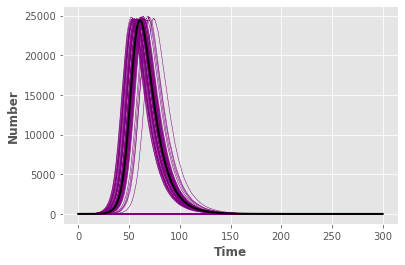

In [8]:
tic = time.time()
for i in range(0,100):
    sir_out = pd.DataFrame(SIRSto(5, 100000, 0.1, 1, 300, 301, 70))
    plt.style.use("ggplot")
    line = plt.plot("t","I","",data=sir_out,color="purple",linewidth=0.5)
    plt.xlabel("Time",fontweight="bold")
    plt.ylabel("Number",fontweight="bold")
toc = time.time()
print(toc-tic)

linedet = plt.plot("t","I","",data=sir_out_det,color="black",linewidth=2)

In [19]:
# finds actual effectiveness of vaccine over 100 stochastic trials
#filters out effectivenesses of 100% as these occur when no outbreak has happened mathematically
#potentially skewed by very minor outbreaks meaning less vaccinated people come into contact with infected people
Actual_eff = []
for i in range(0,100):
    sir_out = pd.DataFrame(SIRSto(5, 100000, 0.1, 1, 300, 50, 82))
    v_max = (np.max(sir_out["Cumulative Vaccinated"]))
    v_fin = sir_out["Vaccinated"].iloc[-1]
    Actual_eff.append((v_fin/v_max)*100)
    
    
F_Actual_eff = []
for i in range(0, len(Actual_eff)):
    if Actual_eff[i] != 100.0:
        F_Actual_eff.append(Actual_eff[i])

np.average(F_Actual_eff)

81.87789763191864

In [ ]:
#finds actual effectiveness of vaccine in deterministic model
sir_out_det = pd.DataFrame(SIRDet(5, 100000, 0.1, 1, 300, 50, 70))
v_max = (np.max(sir_out_det["V_c"]))
v_fin = sir_out_det["V"].iloc[-1]
print((v_fin/v_max)*100)

In [ ]:
#Everything beyond this point for simple testing purposes only

In [69]:
g = np.zeros((3,3,2))
T = np.zeros(3)
g[0,0,1] = 3
g[1,2,1] = 6
g[1,0,1] = 2
g[1,0,0] = 5
print(g)
print(g[1,])

np.sum(g[:,2,1])
np.sum(g[1,])
T[0] = np.sum(g[0,])
T[1] = np.sum(g[1,])
T[2] = np.sum(g[2,])

print(T)

[[[0. 3.]
  [0. 0.]
  [0. 0.]]

 [[5. 2.]
  [0. 0.]
  [0. 6.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]]]
[[5. 2.]
 [0. 0.]
 [0. 6.]]
[ 3. 13.  0.]


In [151]:
A = np.random.multinomial(3, [1/3,1/3])
print(A)

B = 1

[2 1]
